In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics.pairwise import euclidean_distances
from tqdm.auto import tqdm
from joblib import Parallel, delayed

### Define parameters

In [2]:
probability_left_ranges = [0.125, 0.25, 0.5, 0.75, 0.875] # the prior probabilities
sigma_likelihood = 5 # the baseline noise in the signal relevant dimenions
sigma_likelihood_irrelevant = 5 # the baseline noise in the signal irrelevant dimension

### Generate distributions

In [3]:
def gaussian(x, mu=0, sig=1):
    return np.exp(-np.power(x - mu, 2.0) / (2 * np.power(sig, 2.0)))


def psychometric(p, x):
    return p["_max"] + (
        (p["_min"] - p["_max"]) / (1 + (x / p["inflection"]) ** p["slope"])
    )


def generate_prior(p_left, rigid_prior=False):
    if rigid_prior:
        prior_probability = np.concatenate(
            [np.ones(n_half) * p_left, np.ones(n_half) * (1 - p_left)]
        )
    else:
        prior_probability = psychometric(
            p={
                "_min": p_left,
                "_max": 1 - p_left,
                "inflection": len(x_true) / 2,
                "slope": 50,
            },
            x=np.arange(len(x_true)),
        )
    prior_probability = prior_probability / np.sum(prior_probability)
    return prior_probability

In [4]:
# We generate the 128 point stimulus dimension. 
#. to avoid edge effects, we allow x_true to go past -64 to 64
x_true = np.arange(-100, 100)
n_half = int(len(x_true) / 2)
decision_boundary = np.concatenate([np.zeros(n_half), np.ones(n_half)])
bounds = [n_half - 64, n_half + 64]
x_true_bds = [x_true[n_half] - 64, x_true[n_half] + 64]
point_indices = np.arange(len(x_true))

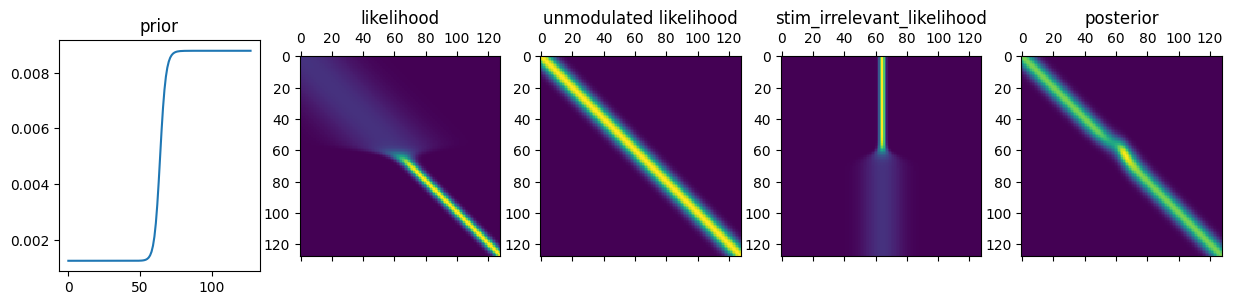

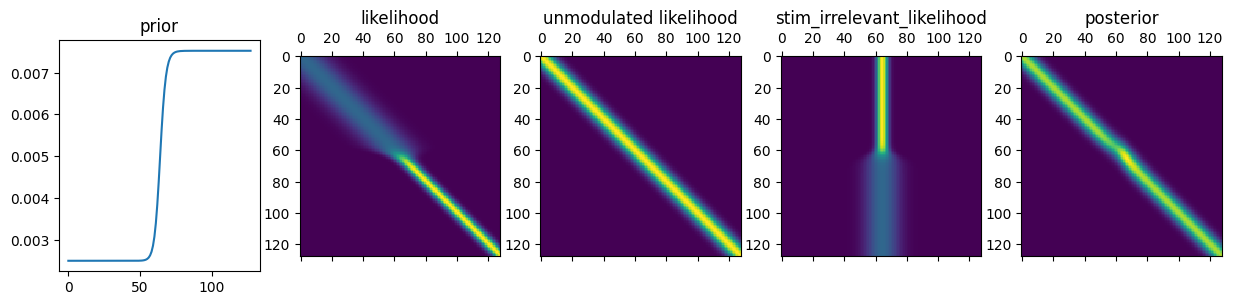

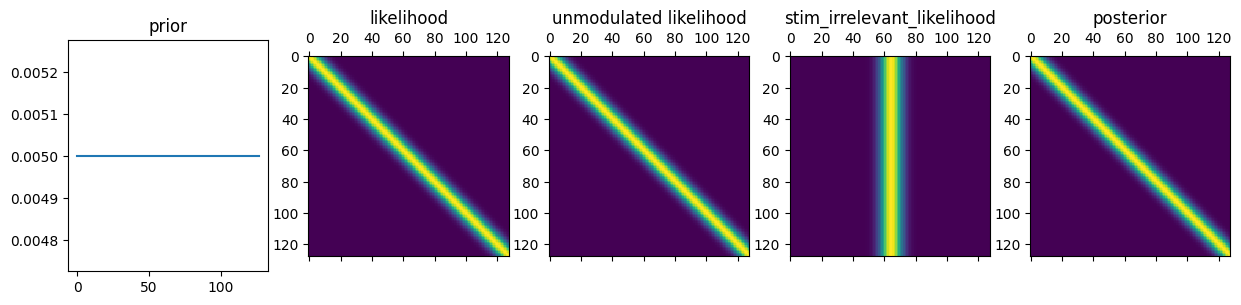

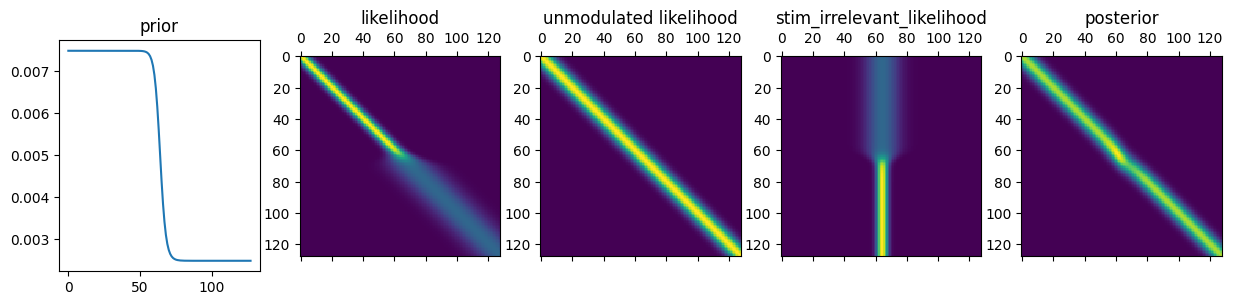

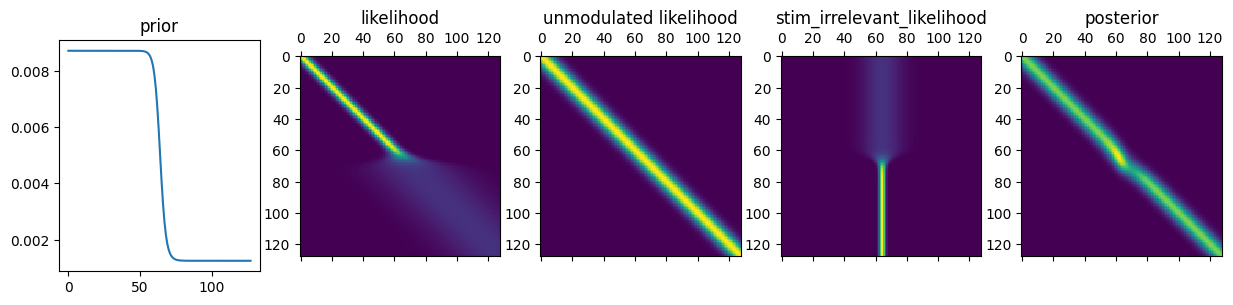

In [5]:
probability_distributions = {}
for p_left in probability_left_ranges:
    # get the prior probability
    prior = generate_prior(p_left, rigid_prior=False)

    # compute the sigma of the likelihood, relative to the prior
    prior_sigma = [sigma_likelihood / (prior_i / (1 / len(prior))) for prior_i in prior]

    # compute the liklihood, assuming the likelihood is not modulated by expectation
    unmodulated_likelihood = np.array(
        [
            gaussian(x_true, x_i, sigma_likelihood)
            for sig_i, x_i in zip(prior_sigma, x_true)
        ]
    )
    unmodulated_likelihood = np.array(
        [i / np.sum(i) for i in unmodulated_likelihood]
    )  # normalize likelihood gaussian to sum to 1

    # additionally, compute the liklihood assuming likelihood is modulated by expectation
    likelihood = np.array(
        [gaussian(x_true, x_i, sig_i) for sig_i, x_i in zip(prior_sigma, x_true)]
    )
    likelihood = np.array(
        [i / np.sum(i) for i in likelihood]
    )  # normalize likelihood gaussian to sum to 1

    # compute the sigma of the likelihood for the stim irrelevant dimension
    prior_sigma_irrelevant = [
        sigma_likelihood_irrelevant / ((1 / len(prior)) / prior_i) for prior_i in prior
    ]

    # compute the stim irrelevant likelihood
    behav_irrelevant_likelihood = np.array(
        [
            gaussian(x_true, 0, sig_i)
            for sig_i, x_i in zip(prior_sigma_irrelevant, x_true)
        ]
    )
    behav_irrelevant_likelihood = np.array(
        [i / np.sum(i) for i in behav_irrelevant_likelihood]
    )  # normalize likelihood gaussian to sum to 1

    # calculate the posterior probability
    posterior = unmodulated_likelihood * prior

    posterior = np.array(
        [i / np.sum(i) for i in posterior]
    )  # normalize posterior probability to sum to 1

    # plot results
    fig, axs = plt.subplots(ncols=5, figsize=(15, 3))
    ax = axs[0]
    ax.plot(prior[bounds[0] : bounds[1]])
    ax.set_title("prior")
    ax = axs[1]
    ax.matshow(likelihood[bounds[0] : bounds[1], bounds[0] : bounds[1]])
    ax.set_title("likelihood")
    ax = axs[2]
    ax.matshow(unmodulated_likelihood[bounds[0] : bounds[1], bounds[0] : bounds[1]])
    ax.set_title("unmodulated likelihood")
    ax = axs[3]
    ax.matshow(behav_irrelevant_likelihood[bounds[0] : bounds[1], bounds[0] : bounds[1]])
    ax.set_title("behav_irrelevant_likelihood")
    ax = axs[4]
    ax.matshow(posterior[bounds[0] : bounds[1], bounds[0] : bounds[1]])
    ax.set_title("posterior")
    plt.show()

    # save probability distributions to a dictionary for sampling
    probability_distributions[p_left] = {
        "prior": prior,
        "likelihood": likelihood,
        "unmodulated_likelihood": unmodulated_likelihood,
        "behav_irrelevant_likelihood": behav_irrelevant_likelihood,
        "posterior": posterior,
    }

### Sample from posterior distributions and compute similarity

In [6]:
def compute_similarity(x_true, perceived, i, point_indices):
    xi = perceived[x_true == i]
    row = np.zeros(len(point_indices))
    for j in point_indices:
        if i > j:
            continue
        xj = perceived[x_true == j]
        sm = 1 / (1 + euclidean_distances(xi, xj))
        if i == j:
            sm = sm[np.tril_indices(len(sm), k=-1)]
        row[j] = np.mean(sm)
    return i, row


def compute_similarity_matrix(x_true, perceived, point_indices):
    mean_sm = np.zeros((len(point_indices), len(point_indices)))
    results = Parallel(n_jobs=-1)(
        delayed(compute_similarity)(x_true, perceived, i, point_indices)
        for i in tqdm(point_indices, desc="computing similarity", leave=False)
    )
    for i, row in results:
        mean_sm[i, :] += row
        row[i] = 0
        mean_sm[:, i] += row
    return mean_sm

def sample_from_distribution(distribution):
    return np.concatenate(
      [
          np.random.choice(point_indices, size=n_samples_per_x_true, p=distribution[i])
          for i in point_indices
      ]
  )

In [7]:
# how many points to sample from each morph position
#.  (increase these values to make the plot smoother)
n_samples_per_x_true = 200 # exponentially expensive (not reccomended to touch)
n_repeated_measures = 10 # linearly expensive (do touch)

In [8]:
similarity_matrices = {}
for p_left in [0.875, 0.125]:
    # the true value of the sampled points
    sample_relevant_true = np.concatenate(
        [np.repeat(i, n_samples_per_x_true) for i in point_indices]
    )
    
    # repeat measurement a few times. Alternatively, you can increase the
    #.  number of samples, but that is more RAM intensive (increasing n_repeated_measures
    #.  increases ram use linearly, increasing n_samples_per_x_true increases ram usage
    #.  exponentially)
    similarity_matrix_posterior_list = []
    for i in tqdm(range((n_repeated_measures)), leave=False):
        # samples from the distributions corresponding to the true values
        posterior_samples = sample_from_distribution(
            probability_distributions[p_left]["posterior"]
        )
        # compute a simlarity matrix from posterior samples
        similarity_matrix_posterior = compute_similarity_matrix(
            sample_relevant_true, np.expand_dims(posterior_samples, -1), point_indices
        )
        similarity_matrix_posterior_list.append(similarity_matrix_posterior)
    similarity_matrix_posterior = np.mean(similarity_matrix_posterior_list, axis=0)
    
    similarity_matrices[p_left] = {"posterior": similarity_matrix_posterior}

  0%|          | 0/10 [00:00<?, ?it/s]

computing similarity:   0%|          | 0/200 [00:00<?, ?it/s]

computing similarity:   0%|          | 0/200 [00:00<?, ?it/s]

computing similarity:   0%|          | 0/200 [00:00<?, ?it/s]

computing similarity:   0%|          | 0/200 [00:00<?, ?it/s]

computing similarity:   0%|          | 0/200 [00:00<?, ?it/s]

computing similarity:   0%|          | 0/200 [00:00<?, ?it/s]

computing similarity:   0%|          | 0/200 [00:00<?, ?it/s]

computing similarity:   0%|          | 0/200 [00:00<?, ?it/s]

computing similarity:   0%|          | 0/200 [00:00<?, ?it/s]

computing similarity:   0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

computing similarity:   0%|          | 0/200 [00:00<?, ?it/s]

computing similarity:   0%|          | 0/200 [00:00<?, ?it/s]

computing similarity:   0%|          | 0/200 [00:00<?, ?it/s]

computing similarity:   0%|          | 0/200 [00:00<?, ?it/s]

computing similarity:   0%|          | 0/200 [00:00<?, ?it/s]

computing similarity:   0%|          | 0/200 [00:00<?, ?it/s]

computing similarity:   0%|          | 0/200 [00:00<?, ?it/s]

computing similarity:   0%|          | 0/200 [00:00<?, ?it/s]

computing similarity:   0%|          | 0/200 [00:00<?, ?it/s]

computing similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Posterior similarity difference \n cue left minus cue right')

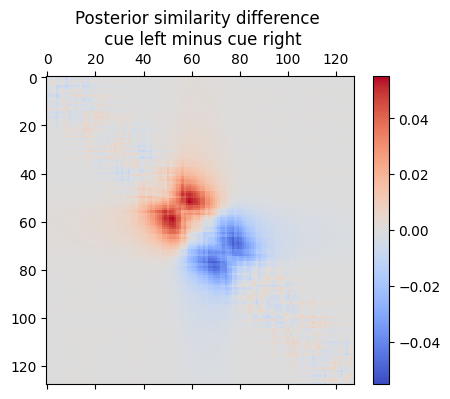

In [9]:
ps_left = similarity_matrices[0.875]["posterior"][bounds[0] : bounds[1], bounds[0] : bounds[1]]
ps_right = similarity_matrices[0.125]["posterior"][
    bounds[0] : bounds[1], bounds[0] : bounds[1]
]
ps_diff = ps_left - ps_right

fig, ax = plt.subplots(figsize=(5,4))
mat = ax.matshow(
    ps_diff,
    cmap=plt.cm.coolwarm,
    vmin=-np.max(np.abs(ps_diff)),
    vmax=np.max(np.abs(ps_diff)),
)
plt.colorbar(mat)
ax.set_title('Posterior similarity difference \n cue left minus cue right')

### Posterior similarity as a function of behaviorally irrelevant dimensions

In [10]:
# how many points to sample from each morph position
#.  (increase these values to make the plot smoother)
n_samples_per_x_true = 200 

In [11]:
similarity_matrices = {}

for n_behav_irrelevant_dimensions in tqdm(np.arange(5)):
    
    similarity_matrices[n_behav_irrelevant_dimensions] = {}
    
    for p_left in [0.25, 0.75]:
        # the true value of the sampled points
        sample_relevant_true = np.concatenate(
            [np.repeat(i, n_samples_per_x_true) for i in point_indices]
        )

        # samples from the distributions corresponding to the true values
        samples = [sample_from_distribution(
            probability_distributions[p_left]['likelihood']
        )]

        for i in range(n_behav_irrelevant_dimensions):
            samples.append(sample_from_distribution(
              probability_distributions[p_left]['behav_irrelevant_likelihood']
            ))
        samples = np.stack(samples).T

        # compute similarity of the percieved sample
        similarity_matrix = compute_similarity_matrix(
            sample_relevant_true, samples, point_indices
        )
        similarity_matrices[n_behav_irrelevant_dimensions][p_left] = similarity_matrix

  0%|          | 0/5 [00:00<?, ?it/s]

computing similarity:   0%|          | 0/200 [00:00<?, ?it/s]

computing similarity:   0%|          | 0/200 [00:00<?, ?it/s]

computing similarity:   0%|          | 0/200 [00:00<?, ?it/s]

computing similarity:   0%|          | 0/200 [00:00<?, ?it/s]

computing similarity:   0%|          | 0/200 [00:00<?, ?it/s]

computing similarity:   0%|          | 0/200 [00:00<?, ?it/s]

computing similarity:   0%|          | 0/200 [00:00<?, ?it/s]

computing similarity:   0%|          | 0/200 [00:00<?, ?it/s]

computing similarity:   0%|          | 0/200 [00:00<?, ?it/s]

computing similarity:   0%|          | 0/200 [00:00<?, ?it/s]

In [12]:
n_behav_irrelevant_dimensions

4

In [13]:
from cdcp.paths import DATA_PATH_MAGPI, FIGURE_DIR, ensure_dir
from cdcp.general import save_fig
save_figs=True

0it [00:00, ?it/s]

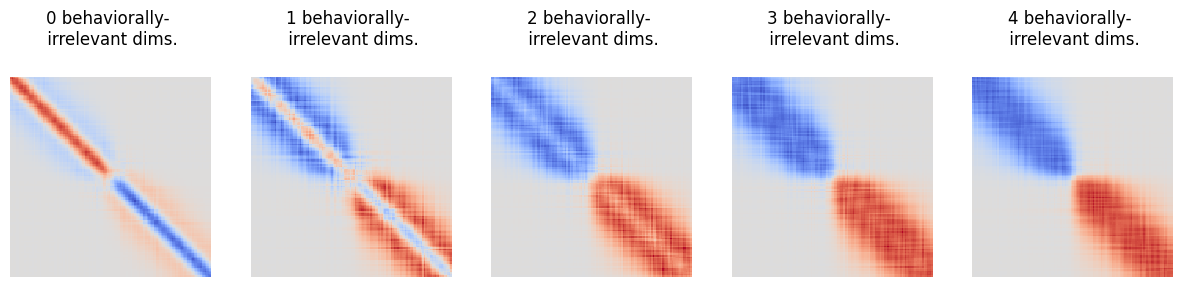

In [63]:
fig, axs = plt.subplots(ncols=5, figsize=(15,3))
for axi, n_behav_irrelevant_dimensions in tqdm(enumerate(np.arange(5))):

    ps_left = similarity_matrices[n_behav_irrelevant_dimensions][0.75][bounds[0] : bounds[1], bounds[0] : bounds[1]]
    ps_right = similarity_matrices[n_behav_irrelevant_dimensions][0.25][
        bounds[0] : bounds[1], bounds[0] : bounds[1]
    ]
    ps_diff = ps_left - ps_right

    ax = axs.flatten()[axi]
    mat = ax.matshow(
        ps_diff,
        cmap=plt.cm.coolwarm,
        vmin=-np.max(np.abs(ps_diff)),
        vmax=np.max(np.abs(ps_diff)),
    )
    ax.set_title(f'{n_behav_irrelevant_dimensions} behaviorally- \n irrelevant dims.')
    ax.axis('off')
ensure_dir(FIGURE_DIR / 'zero_sum_model')
if save_figs:
    save_fig(FIGURE_DIR / 'zero_sum_model'/ 'vary-dimensions', save_pdf=True)
plt.show()

### Plot an example of the samples for 1 behaviorally-irrelevant dimension

In [15]:
sample_relevant_true = np.concatenate(
    [np.repeat(i, n_samples_per_x_true) for i in point_indices]
)

sample_relevant = sample_from_distribution(
    probability_distributions[p_left]["likelihood"]
)

sample_irrelevant = sample_from_distribution(
    probability_distributions[p_left]["behav_irrelevant_likelihood"]
)

m = (sample_relevant_true == 75) | (sample_relevant_true == 125)
df = pd.DataFrame(
    np.transpose(
        [
            sample_relevant_true[m],
            sample_relevant[m],
            sample_irrelevant[m],
        ]
    ),
    columns=["sample_relevant_true", "sample_relevant_perceived", "sample_irrelevant_perceived"],
)

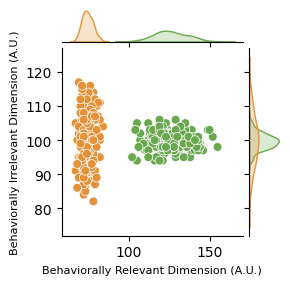

In [16]:
# Set up your custom settings
joint_kws = {"s": 40}
marginal_kws = {"color": "purple"}

# Create the jointplot
g = sns.jointplot(
    data=df,
    x="sample_relevant_perceived",
    y="sample_irrelevant_perceived",
    hue="sample_relevant_true",
    palette=sns.color_palette(["#e69138", "#6aa84f"]),
    joint_kws=joint_kws,
    marginal_kws=marginal_kws,
    height=3,
)
g.ax_joint.set_xlabel("Behaviorally Relevant Dimension (A.U.)", fontsize=8)
g.ax_joint.set_ylabel("Behaviorally Irrelevant Dimension (A.U.)", fontsize=8)

g.ax_joint.legend().set_visible(False)

ensure_dir(FIGURE_DIR / 'zero_sum_model')
if save_figs:
    save_fig(FIGURE_DIR / 'zero_sum_model'/ 'zero_sum_model', save_pdf=True)
plt.show()

### Plot examples of likelihood shift

[]

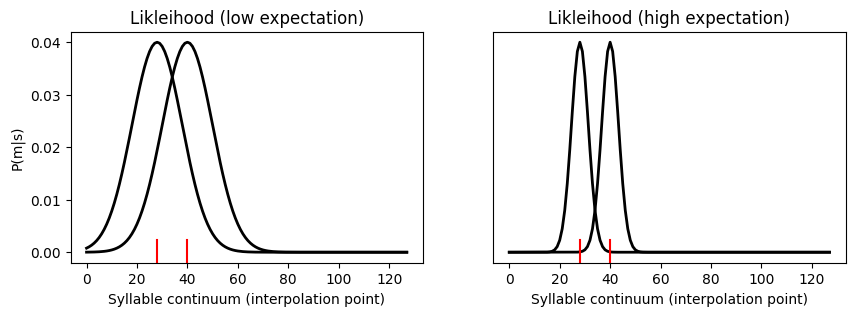

In [61]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10,3))
pt0 = 44 + 32
pt1 = 32 + 32
pt2 = 34 + 32
pt3 = 32 + 32
lw = 2

ax = axs[0]
ax.plot(probability_distributions[0.25]['likelihood'][pt0][bounds[0]:bounds[1]], color = 'k', lw=lw)
ax.plot(probability_distributions[0.25]['likelihood'][pt1][bounds[0]:bounds[1]], color = 'k', lw=lw)
ax.set_ylabel('P(m|s)')
ax.set_title('Likleihood (low expectation)')
ax.axvline(pt0 - bounds[0], color = 'red', ymin=0, ymax=0.1)
ax.axvline(pt1 - bounds[0], color = 'red', ymin=0, ymax=0.1)
ax.set_xlabel('Syllable continuum (interpolation point)')

ax = axs[1]
ax.set_title('Likleihood (high expectation)')
ax.plot(probability_distributions[0.75]['likelihood'][pt0][bounds[0]:bounds[1]], color = 'k', lw=lw)
ax.plot(probability_distributions[0.75]['likelihood'][pt1][bounds[0]:bounds[1]], color = 'k', lw=lw)
ax.set_xlabel('Syllable continuum (interpolation point)')
ax.axvline(pt0 - bounds[0], color = 'red', ymin=0, ymax=0.1)
ax.axvline(pt1 - bounds[0], color = 'red', ymin=0, ymax=0.1)
ax.set_yticks([])


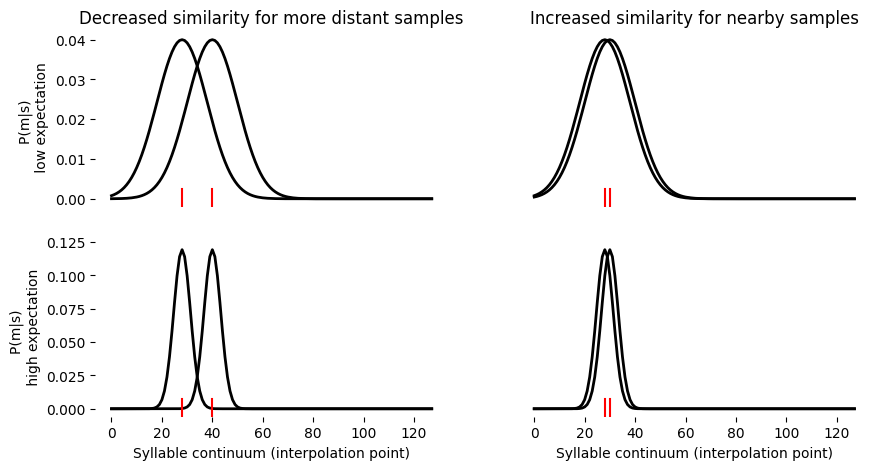

In [17]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10,5))
pt0 = 44 + 32
pt1 = 32 + 32
pt2 = 34 + 32
pt3 = 32 + 32
lw = 2

ax = axs[0,0]
ax.plot(probability_distributions[0.25]['likelihood'][pt0][bounds[0]:bounds[1]], color = 'k', lw=lw)
ax.plot(probability_distributions[0.25]['likelihood'][pt1][bounds[0]:bounds[1]], color = 'k', lw=lw)
ax.set_ylabel('P(m|s) \n low expectation')
ax.set_title('Decreased similarity for more distant samples')
ax.set_xticks([])
ax.axvline(pt0 - bounds[0], color = 'red', ymin=0, ymax=0.1)
ax.axvline(pt1 - bounds[0], color = 'red', ymin=0, ymax=0.1)

ax = axs[1,0]
ax.plot(probability_distributions[0.75]['likelihood'][pt0][bounds[0]:bounds[1]], color = 'k', lw=lw)
ax.plot(probability_distributions[0.75]['likelihood'][pt1][bounds[0]:bounds[1]], color = 'k', lw=lw)
ax.set_ylabel('P(m|s) \n high expectation')
ax.set_xlabel('Syllable continuum (interpolation point)')
ax.axvline(pt0 - bounds[0], color = 'red', ymin=0, ymax=0.1)
ax.axvline(pt1 - bounds[0], color = 'red', ymin=0, ymax=0.1)

ax = axs[0,1]
ax.plot(probability_distributions[0.25]['likelihood'][pt2][bounds[0]:bounds[1]], color = 'k', lw=lw)
ax.plot(probability_distributions[0.25]['likelihood'][pt3][bounds[0]:bounds[1]], color = 'k', lw=lw)
ax.set_yticks([]) 
ax.set_title('Increased similarity for nearby samples')
ax.set_xticks([])
ax.axvline(pt2 - bounds[0], color = 'red', ymin=0, ymax=0.1)
ax.axvline(pt3 - bounds[0], color = 'red', ymin=0, ymax=0.1)

ax = axs[1,1]
ax.plot(probability_distributions[0.75]['likelihood'][pt2][bounds[0]:bounds[1]], color = 'k', lw=lw)
ax.plot(probability_distributions[0.75]['likelihood'][pt3][bounds[0]:bounds[1]], color = 'k', lw=lw)
ax.set_yticks([])
ax.set_xlabel('Syllable continuum (interpolation point)')
ax.axvline(pt2 - bounds[0], color = 'red', ymin=0, ymax=0.1)
ax.axvline(pt3 - bounds[0], color = 'red', ymin=0, ymax=0.1)

for ax in axs.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    


ensure_dir(FIGURE_DIR / 'zero_sum_model')
if save_figs:
    save_fig(FIGURE_DIR / 'zero_sum_model'/ 'similarity-shift-example', save_pdf=True)
plt.show()

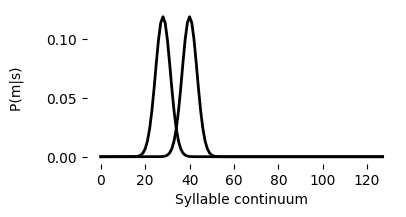

In [79]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4,2))

pt0 = 44 + 32
pt1 = 32 + 32
pt2 = 34 + 32
pt3 = 32 + 32
lw = 2


ax.plot(probability_distributions[0.75]['likelihood'][pt1][bounds[0]:bounds[1]], color = 'k', lw=lw)
ax.plot(probability_distributions[0.75]['likelihood'][pt0][bounds[0]:bounds[1]], color = 'k', lw=lw)
#ax.set_yticks([]) 
#ax.set_title('Increased similarity for nearby samples')
#ax.set_xticks([])
#ax.axvline(pt2 - bounds[0], color = 'red', ymin=0, ymax=0.1)
#ax.axvline(pt3 - bounds[0], color = 'red', ymin=0, ymax=0.1)
ax.set_ylabel('P(m|s) \n')
ax.set_xlabel('Syllable continuum')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
    
plt.show()

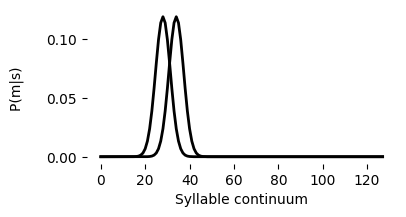

In [80]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4,2))

pt0 = 38 + 32
pt1 = 32 + 32

lw = 2


ax.plot(probability_distributions[0.75]['likelihood'][pt1][bounds[0]:bounds[1]], color = 'k', lw=lw)
ax.plot(probability_distributions[0.75]['likelihood'][pt0][bounds[0]:bounds[1]], color = 'k', lw=lw)
#ax.set_yticks([]) 
#ax.set_title('Increased similarity for nearby samples')
#ax.set_xticks([])
#ax.axvline(pt2 - bounds[0], color = 'red', ymin=0, ymax=0.1)
#ax.axvline(pt3 - bounds[0], color = 'red', ymin=0, ymax=0.1)
ax.set_ylabel('P(m|s) \n')
ax.set_xlabel('Syllable continuum')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
    
plt.show()

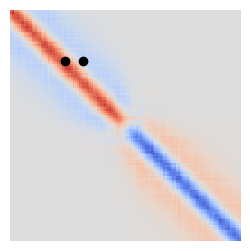

In [18]:
fig, ax = plt.subplots(figsize=(3,3))
n_behav_irrelevant_dimensions = 0
ps_left = similarity_matrices[n_behav_irrelevant_dimensions][0.75][bounds[0] : bounds[1], bounds[0] : bounds[1]]
ps_right = similarity_matrices[n_behav_irrelevant_dimensions][0.25][
    bounds[0] : bounds[1], bounds[0] : bounds[1]
]
ps_diff = ps_left - ps_right
mat = ax.matshow(
    ps_diff,
    cmap=plt.cm.coolwarm,
    vmin=-np.max(np.abs(ps_diff)),
    vmax=np.max(np.abs(ps_diff)),
)

ax.scatter([pt0-bounds[0]], [pt1 - bounds[0]], color = 'k')
ax.scatter([pt2- bounds[0]], [pt3- bounds[0]], color = 'k')

ax.axis('off')
ensure_dir(FIGURE_DIR / 'zero_sum_model')
if save_figs:
    save_fig(FIGURE_DIR / 'zero_sum_model'/ 'similarity-shift-example-similarity-matrix', save_pdf=True)
plt.show()


### 1D example, no behaviorally irrelevant dimensions

In [19]:
n_samples_per_x_true = 1000

In [47]:
def compute_similarity(x_true, perceived, i, point_indices):
    xi = perceived[x_true == i]
    row = np.zeros(len(point_indices))
    for j in point_indices:
        if i > j:
            continue
        xj = perceived[x_true == j]
        sm = 1 / (1 + euclidean_distances(xi, xj))
        if i == j:
            sm = sm[np.tril_indices(len(sm), k=-1)]
        row[j] = np.mean(sm)
    return i, row


def compute_similarity_matrix(x_true, perceived, point_indices):
    mean_sm = np.zeros((len(point_indices), len(point_indices)))
    results = Parallel(n_jobs=-1)(
        delayed(compute_similarity)(x_true, perceived, i, point_indices)
        for i in tqdm(point_indices, desc="computing similarity", leave=False)
    )
    for i, row in results:
        mean_sm[i, :] += row
        row[i] = 0
        mean_sm[:, i] += row
    return mean_sm

def sample_from_distribution(distribution):
    return np.concatenate(
      [
          np.random.choice(point_indices, size=n_samples_per_x_true, p=distribution[i])
          for i in point_indices
      ]
  )

sample_relevant_true = np.concatenate(
    [np.repeat(i, n_samples_per_x_true) for i in point_indices]
)
p = {}
for sigma in [5, 10]:
    
    # additionally, compute the liklihood assuming likelihood is modulated by expectation
    likelihood = np.array(
        [gaussian(x_true, x_i, sigma) for x_i in x_true]
    )
    likelihood = np.array(
        [i / np.sum(i) for i in likelihood]
    )  # normalize likelihood gaussian to sum to 1

    # samples from the distributions corresponding to the true values
    samples = sample_from_distribution(
        likelihood
    )
            
    # compute similarity of the percieved sample
    likelihood_similarity = compute_similarity_matrix(
        sample_relevant_true, np.expand_dims(samples, -1), point_indices
    )

    # save probability distributions to a dictionary for sampling
    p[sigma] = {
        "likelihood": likelihood,
        "likelihood_similarity": likelihood_similarity,
    }

computing similarity:   0%|          | 0/200 [00:00<?, ?it/s]

computing similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Text(0.5, 0, 'Syllable continuum (observed)')

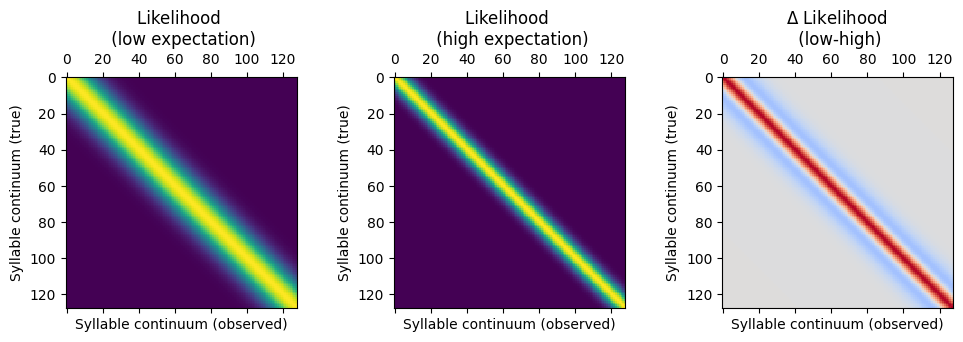

In [57]:
fig, axs = plt.subplots(ncols=3, figsize=(12,3))
sm_high_variance = p[10]["likelihood"][bounds[0]:bounds[1],bounds[0]:bounds[1]]
sm_low_variance = p[5]["likelihood"][bounds[0]:bounds[1],bounds[0]:bounds[1]]
diff = sm_low_variance - sm_high_variance
axs[0].matshow(sm_high_variance)
axs[0].set_title("Likelihood \n (low expectation)")
axs[0].set_ylabel('Syllable continuum (true)')
axs[0].set_xlabel('Syllable continuum (observed)')
axs[1].matshow(sm_low_variance)
axs[1].set_title("Likelihood \n (high expectation)")
axs[1].set_ylabel('Syllable continuum (true)')
axs[1].set_xlabel('Syllable continuum (observed)')
axs[2].matshow(diff, cmap = 'coolwarm', vmin=-np.max(np.abs(diff)), vmax=np.max(np.abs(diff)))
axs[2].set_title("$\Delta$ Likelihood \n (low-high)")
axs[2].set_ylabel('Syllable continuum (true)')
axs[2].set_xlabel('Syllable continuum (observed)')

Text(0.5, 0, 'Syllable continuum')

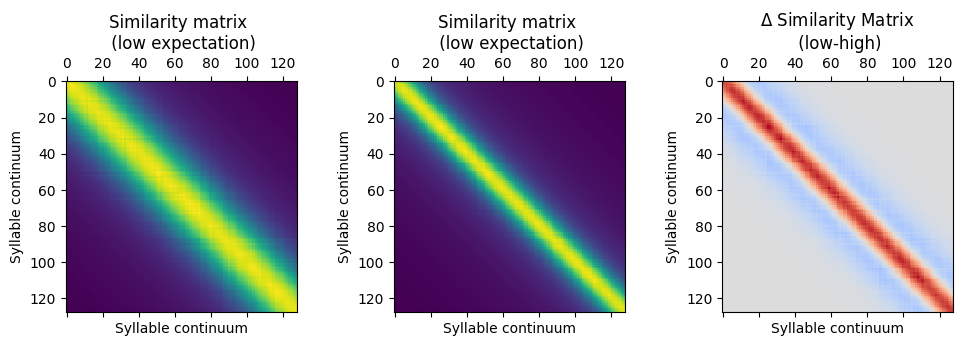

In [56]:
fig, axs = plt.subplots(ncols=3, figsize=(12,3))
sm_high_variance = p[10]["likelihood_similarity"][bounds[0]:bounds[1],bounds[0]:bounds[1]]
sm_low_variance = p[5]["likelihood_similarity"][bounds[0]:bounds[1],bounds[0]:bounds[1]]
diff = sm_low_variance - sm_high_variance
axs[0].matshow(sm_high_variance)
axs[0].set_title("Similarity matrix \n (low expectation)")
axs[0].set_ylabel('Syllable continuum')
axs[0].set_xlabel('Syllable continuum')
axs[1].matshow(sm_low_variance)
axs[1].set_title("Similarity matrix \n (low expectation)")
axs[1].set_ylabel('Syllable continuum')
axs[1].set_xlabel('Syllable continuum')
axs[2].matshow(diff, cmap = 'coolwarm', vmin=-np.max(np.abs(diff)), vmax=np.max(np.abs(diff)))
axs[2].set_title("$\Delta$ Similarity Matrix \n (low-high)")
axs[2].set_ylabel('Syllable continuum')
axs[2].set_xlabel('Syllable continuum')